In [129]:
# ## Hücre 1: Gerekli Kütüphanelerin Yüklenmesi
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt


In [130]:
# ## Hücre 2: Veri Setlerinin Yüklenmesi
ratings = pd.read_csv('ratings.csv')
extended_movie_data = pd.read_csv('final_user_movie_dataset.csv')


In [131]:
# ## Hücre 3: Veri Ön İşleme
# Gereksiz sütunların kaldırılması
ratings = ratings.drop(columns=['timestamp'])
# Veri setlerinin birleştirilmesi
merged_df = pd.merge(ratings, extended_movie_data, on='movieId')
# Türlerin ayrıştırılması
genres_split = merged_df['genres'].str.get_dummies(sep='|')
merged_df = pd.concat([merged_df, genres_split], axis=1)

In [132]:
# ## Hücre 4: Özet İstatistiklerin Hesaplanması
# Kullanıcı başına ortalama puan
user_avg_rating = merged_df.groupby('userId')['rating'].mean().reset_index()
user_avg_rating.rename(columns={'rating': 'avg_user_rating'}, inplace=True)

# Film başına ortalama puan
movie_avg_rating = merged_df.groupby('movieId')['rating'].mean().reset_index()
movie_avg_rating.rename(columns={'rating': 'avg_movie_rating'}, inplace=True)

# Kullanıcı-tür ortalamaları
user_genre_avg = merged_df.groupby('userId')[list(genres_split.columns)].mean().reset_index()
user_genre_avg.columns = ['userId'] + [f'user_avg_{col}' for col in genres_split.columns]
merged_df = pd.merge(merged_df, user_genre_avg, on='userId', how='left')
merged_df = pd.merge(merged_df, user_avg_rating, on='userId', how='left')
merged_df = pd.merge(merged_df, movie_avg_rating, on='movieId', how='left')

In [133]:
# ## Hücre 4: Plot Keywords - TF-IDF Dönüşümü
# TF-IDF ile plot_keywords özelliği çıkarımı
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'), max_features=20)
tfidf_matrix = tfidf.fit_transform(merged_df['plot_keywords'].fillna(''))

# TF-IDF Matrisini Veri Setine Ekleyelim
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

from sklearn.decomposition import PCA

# PCA ile boyutları 50'ye indirme
pca = PCA(n_components=20)
tfidf_pca = pca.fit_transform(tfidf_df)

# PCA sonuçlarını veri setine ekleme
tfidf_pca_df = pd.DataFrame(tfidf_pca, columns=[f'PCA_{i+1}' for i in range(20)])
merged_df = pd.concat([merged_df, tfidf_pca_df], axis=1)

#merged_df = pd.concat([merged_df, tfidf_df], axis=1)

merged_df.head()

c:\Users\umuro\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,userId,movieId,rating,title,genres,director_name,imdb_score,duration,budget,language,...,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,John Lasseter,8.3,74.0,30000000.0,English,...,-0.000015,-0.022627,-0.007357,-0.010903,-0.023386,-0.010041,-0.005065,0.011598,-0.049732,-0.015227
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,John Lasseter,8.3,74.0,30000000.0,English,...,-0.000015,-0.022627,-0.007357,-0.010903,-0.023386,-0.010041,-0.005065,0.011598,-0.049732,-0.015227
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,John Lasseter,8.3,74.0,30000000.0,English,...,-0.000015,-0.022627,-0.007357,-0.010903,-0.023386,-0.010041,-0.005065,0.011598,-0.049732,-0.015227
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,John Lasseter,8.3,74.0,30000000.0,English,...,-0.000015,-0.022627,-0.007357,-0.010903,-0.023386,-0.010041,-0.005065,0.011598,-0.049732,-0.015227
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,John Lasseter,8.3,74.0,30000000.0,English,...,-0.000015,-0.022627,-0.007357,-0.010903,-0.023386,-0.010041,-0.005065,0.011598,-0.049732,-0.015227


In [134]:
from sklearn.preprocessing import LabelEncoder

# ## Hücre 4.1: String Değişkenleri Sayısal Hale Getirme
# Label Encoding ile dönüştürme
label_encoder_language = LabelEncoder()
label_encoder_country = LabelEncoder()
label_encoder_director = LabelEncoder()

merged_df['language_encoded'] = label_encoder_language.fit_transform(merged_df['language'].fillna('Unknown'))
merged_df['country_encoded'] = label_encoder_country.fit_transform(merged_df['country'].fillna('Unknown'))
merged_df['director_encoded'] = label_encoder_director.fit_transform(merged_df['director_name'].fillna('Unknown'))

# Orijinal string sütunları kaldırma
merged_df = merged_df.drop(columns=['language', 'country', 'director_name'])
print("Categorical columns have been label encoded.")
merged_df.head()

Categorical columns have been label encoded.


,userId,movieId,rating,title,genres,imdb_score,duration,budget,content_rating,num_voted_users,...,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,language_encoded,country_encoded,director_encoded
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.3,74.0,30000000.0,G,623757,...,-0.010903,-0.023386,-0.010041,-0.005065,0.011598,-0.049732,-0.015227,7,40,670
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.3,74.0,30000000.0,G,623757,...,-0.010903,-0.023386,-0.010041,-0.005065,0.011598,-0.049732,-0.015227,7,40,670
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.3,74.0,30000000.0,G,623757,...,-0.010903,-0.023386,-0.010041,-0.005065,0.011598,-0.049732,-0.015227,7,40,670
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.3,74.0,30000000.0,G,623757,...,-0.010903,-0.023386,-0.010041,-0.005065,0.011598,-0.049732,-0.015227,7,40,670
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.3,74.0,30000000.0,G,623757,...,-0.010903,-0.023386,-0.010041,-0.005065,0.011598,-0.049732,-0.015227,7,40,670


In [136]:
# ## Hücre 6: Model için Feature Vektörünün Oluşturulması
# Kullanılacak özellikler ve hedef değişken
from sklearn.preprocessing import StandardScaler

target = 'rating'
features = (
    ['avg_user_rating', 'avg_movie_rating', 'imdb_score'
     , 'duration', 'budget', 'country_encoded', 'language_encoded', 'director_encoded', 'num_voted_users' ] +  
    list(user_genre_avg.columns[1:]) + 
    tfidf_pca_df.columns.tolist()  
)

x = merged_df[features]
y = merged_df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)


In [137]:
# ## Hücre 7: Linear Regression ile Test
# Eğitim ve test setlerinin ayrılması
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [139]:
# Modellerin tanımlanması
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Lasso Regression' : Lasso(alpha=0.1, random_state=42),
    'ElasticNet' : ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    'KNN Regression' : KNeighborsRegressor(n_neighbors=3)
}

# Modellerin eğitilmesi ve değerlendirilmesi
results = []
y_preds = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    #y_pred = model.predict(X_test)
    y_preds[model_name] = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_preds[model_name])
    rmse = np.sqrt(mean_squared_error(y_test, y_preds[model_name]))
    results.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse})
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Sonuçların bir DataFrame olarak gösterilmesi
results_df = pd.DataFrame(results)
print("\nPerformance Comparison:")
print(results_df)


Linear Regression - MAE: 0.6254, RMSE: 0.8191
Ridge Regression - MAE: 0.6254, RMSE: 0.8191
Lasso Regression - MAE: 0.6404, RMSE: 0.8339
Decision Tree - MAE: 0.8123, RMSE: 1.1365
Gradient Boosting - MAE: 0.6203, RMSE: 0.8126
ElasticNet - MAE: 0.6352, RMSE: 0.8292
KNN Regression - MAE: 0.6970, RMSE: 0.9266

Performance Comparison:
               Model       MAE      RMSE
0  Linear Regression  0.625387  0.819075
1   Ridge Regression  0.625387  0.819075
2   Lasso Regression  0.640364  0.833895
3      Decision Tree  0.812277  1.136537
4  Gradient Boosting  0.620290  0.812621
5         ElasticNet  0.635238  0.829197
6     KNN Regression  0.696967  0.926600


In [141]:
# ## Hücre 8: Her Bir Data Noktası İçin En İyi Tahminin Seçilmesi 
# (bu hücre her modelde en iyi değeri alarak bir grafik 
# oluşturuyor ve modellerin farklı data pointlerde farklı tahminler yaptığını gösteriyor. 
# Akademide kabul edilmiş bir metrik hesaplayıcısı değildir. Deneme amacıyla yapılmıştır)
best_predictions = []
for i in range(len(y_test)):
    min_error = float('inf')
    best_model_prediction = None
    for model_name, predictions in y_preds.items():
        error = abs(predictions[i] - y_test.iloc[i])
        if error < min_error:
            min_error = error
            best_model_prediction = predictions[i]
    best_predictions.append(best_model_prediction)

# Gerçek ve en iyi tahminlerin karşılaştırılması
best_predictions = pd.Series(best_predictions, index=y_test.index)
mae_best = mean_absolute_error(y_test, best_predictions)
rmse_best = np.sqrt(mean_squared_error(y_test, best_predictions))

print(f"Best Model Combination Results:\nMAE: {mae_best:.4f}\nRMSE: {rmse_best:.4f}")


Best Model Combination Results:
MAE: 0.3235
RMSE: 0.5558


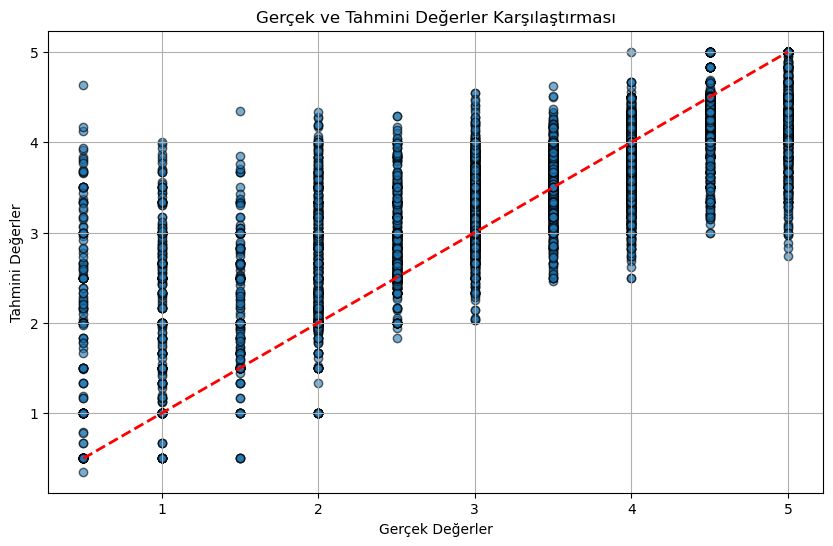

In [143]:
# 12. Veri Setini Görüntüleme
pd.set_option('display.max_columns', None)  # Tüm sütunları göstermek için ayar
pd.set_option('display.width', 1000)       # Genişliği artırarak düzgün görüntüleme


plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_predictions, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Referans çizgisi
plt.title('Gerçek ve Tahmini Değerler Karşılaştırması')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmini Değerler')
plt.grid(True)
plt.show()